<a href="https://colab.research.google.com/github/mardydu/MissingPixelsProject/blob/main/MissingPixels_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import os
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

from scipy import signal
import cv2 as cv
# import ipcv_utils.utils as ipcv_plt

import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# from imutils import imshow as aiimshow


In [76]:
# LOAD AND CREATE THE DATA
(X_trn, _), (X_tst, _) = \
  keras.datasets.cifar10.load_data()

# X_trn = cv.resize(X_trn, (32, 32))
# X_trn = X_trn.astype('float32')

# print("x",X_trn[0])
x_trn = np.copy(X_trn) # to make the missing pixels image
y_trn = np.copy(X_trn) # the original image

x_tst = np.copy(X_tst) # to make the missing pixels image for the testing data
y_tst = np.copy(X_tst) # the original image for the testing data

print("Training set size (length, dims):", x_trn.shape)
print("Testing set size (length, dims):", x_tst.shape)

for img_idx in range(len(x_trn)):\
  mask = x_trn[img_idx]
  num_rows = mask.shape[0]
  num_cols = mask.shape[1]

  idxs = 0 + img_idx

  for r in range(num_rows):
    for c in range(num_cols):
      intv = 2
      size = 1
      x = 0
      y = 0
      while x < 32-intv:
        x += intv
      
        for i in range(size):
          while y < 32-intv:
            y += intv

            for j in range(size):
              mask[x][y] = 0
              y += 1

          x += 1
          y = 0

print("loop train data",idxs+1)

for img_idx2 in range(len(x_tst)):
  mask2 = x_trn[img_idx2]
  num_rows = mask2.shape[0]
  num_cols = mask2.shape[1]
  idxs2 = 0+img_idx2
  for r in range(num_rows):
    for c in range(num_cols):
      intv = 2
      size = 1
      x = 0
      y = 0
      while x < 32-intv:
        x += intv
      
        for i in range(size):
          while y < 32-intv:
            y += intv

            for j in range(size):
              mask2[x][y] = 0
              y += 1

          x += 1
          y = 0

print("loop test data",idxs2+1)

Training set size (length, dims): (50000, 32, 32, 3)
Testing set size (length, dims): (10000, 32, 32, 3)
loop train data 50000
loop test data 10000


<Figure size 720x480 with 0 Axes>

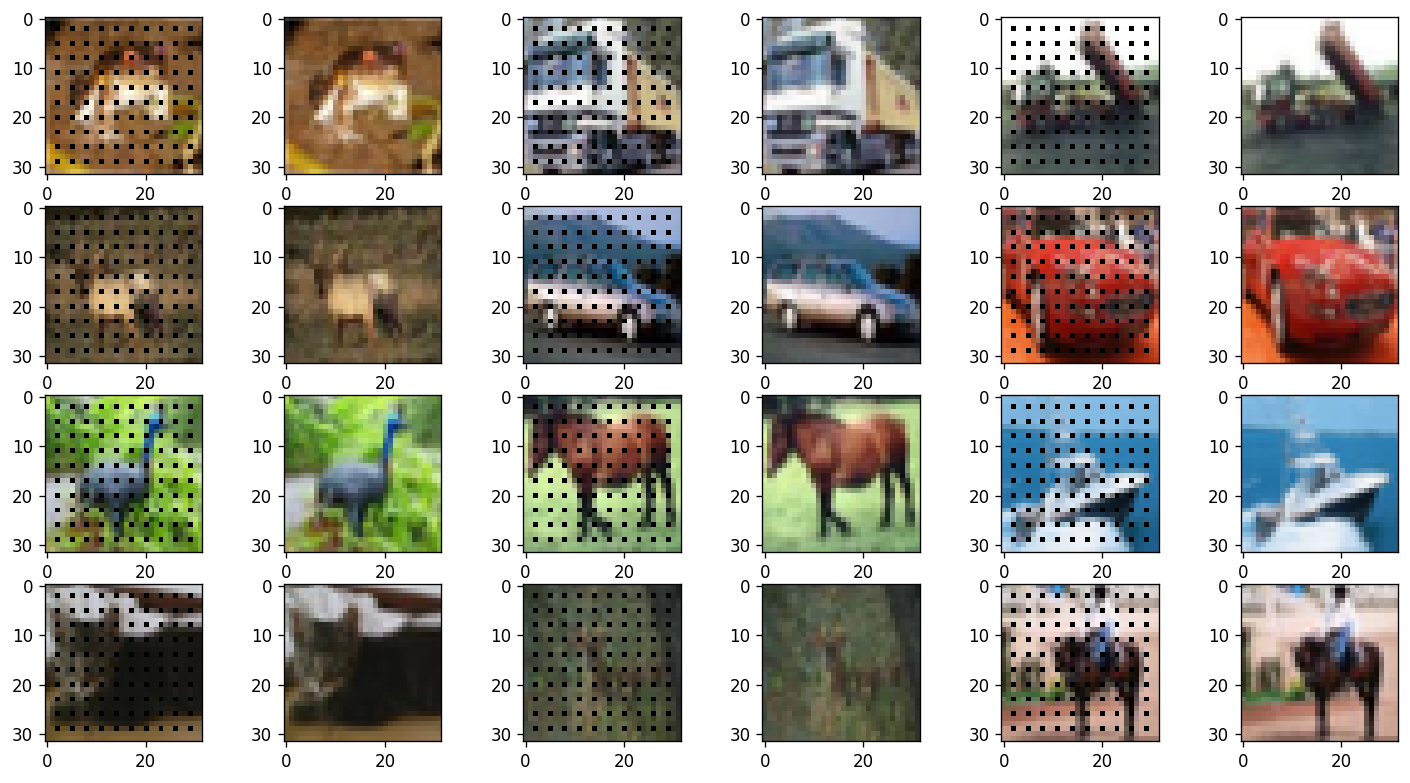

In [92]:
#SHOW THE DATA

plt.figure()
f, axarr = plt.subplots(4, 6, figsize=(15, 8))

i = 0
j = 1
for n in range(3):
  axarr[0][i].imshow(x_trn[n])  
  axarr[0][j].imshow(y_trn[n])
  axarr[1][i].imshow(x_trn[n+3])
  axarr[1][j].imshow(y_trn[n+3])
  axarr[2][i].imshow(x_trn[n+6])  
  axarr[2][j].imshow(y_trn[n+6])
  axarr[3][i].imshow(x_trn[n+9])
  axarr[3][j].imshow(y_trn[n+9])
  

  i += 2
  j += 2

plt.show()

In [93]:
# PREPARE THE MODEL AND DATA

input_img = Input(shape=(32,32,3))

# to be used for training purposes
x_train = x_trn.astype('float32') / 255
y_train = y_trn.astype('float32') / 255
x_test = y_tst.astype('float32') / 255
y_test = y_tst.astype('float32') / 255

#Encoder
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

#Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [94]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_35 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_80 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_81 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_36 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 up_sampling2d_19 (UpSamplin  (None, 32, 32, 32)     

In [95]:
autoencoder=Model(input_img, decoded)

In [96]:
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 8, 8, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 8, 8, 8)           584

In [97]:
encoder = Model(input_img, encoded)

In [98]:
encoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 8, 8, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 8, 8, 8)           584

In [99]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [100]:
# TRAIN THE DATA AND FIT IT TO THE MODEL

history = model.fit(x_train, y_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, y_test))

Epoch 1/50
196/196 [==============================] - 238s 1s/step - loss: 0.0076 - accuracy: 0.6725 - val_loss: 0.0223 - val_accuracy: 0.4872
Epoch 2/50
196/196 [==============================] - 243s 1s/step - loss: 0.0022 - accuracy: 0.7772 - val_loss: 0.0059 - val_accuracy: 0.6986
Epoch 3/50
196/196 [==============================] - 238s 1s/step - loss: 0.0015 - accuracy: 0.8016 - val_loss: 0.0026 - val_accuracy: 0.8063
Epoch 4/50
196/196 [==============================] - 234s 1s/step - loss: 0.0012 - accuracy: 0.8160 - val_loss: 0.0022 - val_accuracy: 0.8183
Epoch 5/50
196/196 [==============================] - 235s 1s/step - loss: 0.0010 - accuracy: 0.8263 - val_loss: 0.0013 - val_accuracy: 0.8011
Epoch 6/50
196/196 [==============================] - 235s 1s/step - loss: 8.6797e-04 - accuracy: 0.8351 - val_loss: 0.0014 - val_accuracy: 0.8322
Epoch 7/50
196/196 [==============================] - 234s 1s/step - loss: 7.9063e-04 - accuracy: 0.8384 - val_loss: 0.0013 - val_accuracy

In [101]:
# SAVE THE PREDICTED VALUE

#encoded_imgs = model.predict(X_test)
predicted = model.predict(x_test)
y_tst_prd = np.argmax(predicted, axis=1)

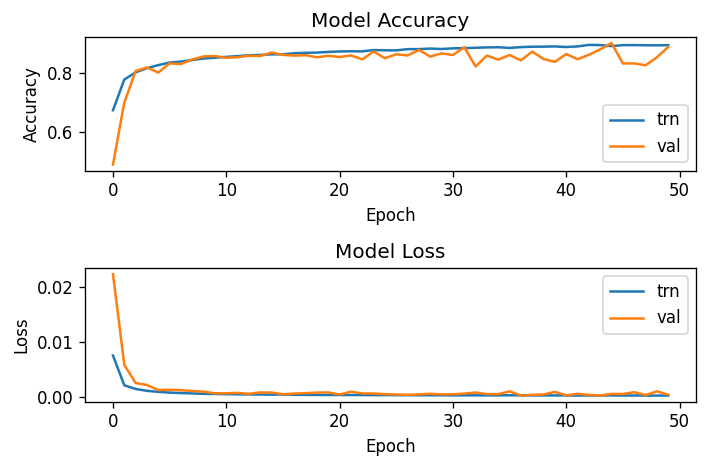

In [102]:
# SHOW THE GRAPHS

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='upper right')

plt.tight_layout()

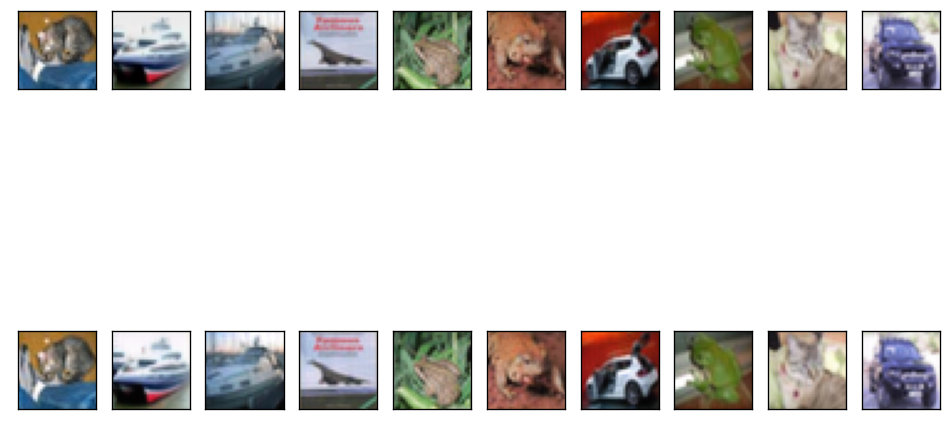

In [156]:
# SHOW THE COMPARATION BETWEEN THE ORIGINAL AND THE PREDICTED IMAGES

plt.figure(figsize=(20,5))
for i in range(10):
    # display original images
    axs = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    #plt.gray()
    axs.get_xaxis().set_visible(False)
    axs.get_yaxis().set_visible(False)
    

    
    # display reconstructed images
    axs = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(32, 32, 3))
    #plt.gray()
    axs.get_xaxis().set_visible(False)
    axs.get_yaxis().set_visible(False)
  
    
plt.show()

MSE = 0.30


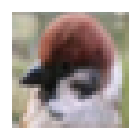

In [169]:
# TESTING ONE OF THE IMAGE FROM 10000 DATA FOR TESTING

anynumber = 4302
imgprd = predicted[anynumber]

masktst = x_tst[anynumber]
num_rows_ori = masktst.shape[0]
num_cols_ori = masktst.shape[1]
ori_img = []
for r in range(num_rows_ori):
  for c in range(num_cols_ori):
    intv_ori = 2
    size_ori = 1
    xax = 0
    yax = 0
    while xax < 32-intv_ori:
      xax += intv_ori
    
      for i in range(size_ori):
        while yax < 32-intv_ori:
          yax += intv_ori

          for j in range(size_ori):
            ori_img.append(masktst[xax][yax])
            yax += 1

        xax += 1
        yax = 0

num_rows_prd = imgprd.shape[0]
num_cols_prd = imgprd.shape[1]
rec_img = []
for r in range(num_rows_prd):
  for c in range(num_cols_prd):
    intv_prd = 2
    size_prd = 1
    xaxp = 0
    yaxp = 0
    while xaxp < 32-intv_prd:
      xaxp += intv_prd
    
      for i in range(size_prd):
        while yaxp < 32-intv_prd:
          yaxp += intv_prd

          for j in range(size_prd):
            rec_img.append(imgprd[xaxp][yaxp])
            yaxp += 1

        xaxp += 1
        yaxp = 0

# TO CALCULATE THE MEAN SQUARED ERROR

rec_img = np.array(rec_img)
ori_img = np.array(ori_img)
rec_img = rec_img.astype('float32')/255
ori_img = ori_img.astype('float32')/255
err = rec_img - ori_img 
print("MSE =", "{:.2f}".format((err**2).mean()))

def imshow(img, cmap=None, vmin=0, vmax=255, frameon=False, dpi=72):
  fig = plt.figure(figsize=[img.shape[1]/dpi, img.shape[0]/dpi], \
                   frameon=frameon)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')
  ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()

imshow(imgprd, dpi=33)
